# Slack Sentiment Analysis

This notebook is a somewhat pointless but simple exercise where we use [Natural Language Toolkit](https://www.nltk.org) models, both pre-trained and trained by us, to figure out if the general sentiment in a slack channel is positive or negative assuming (most likely incorrectly) that we can judge such a thing using amazon, yelp and movie reviews as examples of positive or negative chat.

## Fetch Slack Data


>If you do not want to use a slack channel you don't have to. If you skip ahead to **"Prepare the Data"** you will find some code where you can comment out a bit to use sample data provided by NLTK instead.

To get messages from a slack channel you will need a token that has permissions to read from that channel as well as the ID of the channel. 

**To get the slack channel ID:**

There is probably an easier way but the one I use is to right click the channel name in the channel menu and select "Copy link". The link will look something like <https://your-org.slack.com/archives/C12345>. The channel ID is the last piece. That's C12345 in the example URL. 

**To get a token:**

Setup a bot user following these instructions <https://api.slack.com/bot-users>. 

The OAuth scope must allow `channels:history`. Add the bot user to the channel you wish to read messages from. The channel should be public. I have not tested any of this with private channels. 

The next section assumed you have 2 environment variables:

`SLACK_SENTIMENT_BOT_TOKEN` - The bot token we setup previously.

`SLACK_SENTIMENT_CHANNEL_ID` - The channel ID we retrieved previously.

If you are not familiar with how to setup environment variables , feel free to just replace those values with hardcoded values but obviously be careful not to accidentally push your token up to Github or something like that :)

Incidentally, I do have a post on managing secrets while developing if you're interested: [a post on managing secrets](https://dev.to/ruarfff/managing-local-app-secrets-and-sharing-secrets-with-your-team-34m1).

In [1]:
# Get a timestamp for 7 days ago in a weird way. I need to lean more python. 
# This is only used if we want to limit how far back in time we go for fetching slack messages.
from datetime import timedelta, datetime, date
today = date.today()
week_ago = today - timedelta(days=7)

week_ago_timestamp = (datetime.combine(week_ago, datetime.min.time()) - datetime(1970, 1, 1)) / timedelta(seconds=1)

In [2]:
import os
# Import WebClient from Python SDK (github.com/slackapi/python-slack-sdk)
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
import json
from time import sleep

token = os.environ.get("SLACK_SENTIMENT_BOT_TOKEN")
channel_id = os.environ.get("SLACK_SENTIMENT_CHANNEL_ID")
page_size = 100

client = WebClient(token=token)

conversation_history = []
has_more = True
cursor = None

try:
    while has_more:
        has_more = False
        result = client.conversations_history(
            channel=channel_id, 
            limit=page_size,
            cursor=cursor
            # If you wanted to limit to the last 7 days uncomment the next line and put a , after cursor on the previous line
            # oldest = week_ago_timestamp
        )        
        conversation_history.extend(result["messages"])        
        has_more = result['has_more']
        if result['response_metadata'] is not None:
            print('Still fetching')
            cursor = result['response_metadata']['next_cursor']
            sleep(0.5) # Avoid being rate limited     
    print('Done!')
except SlackApiError as e:
    print("Error getting conversations: {}".format(e))    

Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Still fetching
Done!


## Prepare the Data

We will try a few things out here. We will split out the data into sentences and words using NLTK tokenize methods. We will clean up the data to remove a large amount of noise. 

There are a lof ot pieces in the text that aren't really useful. Punctuation for example. Also things like emojis and various words that don't hold much meaning out of context (NLTK provdes a set of these called "stopwords"). It would actually be useful to include emojis in this kind of analysis but let's keep it simple and exclude them here. 

In [3]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import itertools

# If you do not want to use a slack channel, uncomment this and remove/comment out the next get_test_data function
# def get_test_data():
#    download('state_union')
#    words = nltk.corpus.state_union.words()
#    sentences = sent_tokenize(' '.join(words))
#    return (sentences, words)


def get_test_data():
    all_text = [message['text'] for message in conversation_history if 'text' in message]
    tokenized_text = [sent_tokenize(text) for text in all_text]
    sentences = list(itertools.chain(*tokenized_text))
    tokenized_words = [word_tokenize(sentence) for sentence in sentences]
    words = list(itertools.chain(*tokenized_words))
    return (sentences, words)

main_sentences, main_words = get_test_data()

## Use a Pre-trained Model

Let's look at a fairly simple method to take the data we just prepared and run it through a pre trained model. 

Later we will look at using all the words from the slack chat with a mixture of frequency distribution and naive bayes to gauge the genral sentiment with a model we train. Here we will instead try going over the chat sentence by sentnece and create a pie chart of Positive VS Negative.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ruairi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


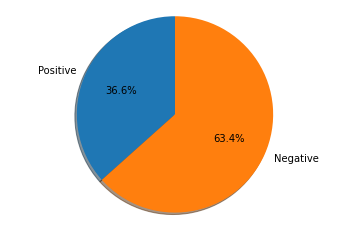

In [4]:
from nltk import download
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

# The SentimentIntensityAnalyzer model needs us to pull down the vader_lexicon
download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

num_pos = 0
num_neg = 0

def is_positive(sentence: str) -> bool:
    return sia.polarity_scores(sentence)["compound"] > 0

for s in main_sentences:
    if is_positive(s):
        num_pos +=1
    else:
        num_neg += 1
        
labels = 'Positive', 'Negative'
sizes = [num_pos, num_neg]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## Clean the Data

From this point on we won't be using the sentences anymore and will focus on the individual words instead. Let's create a frequency distribution graph of the words. This is to demonstrate how many of them are more of less useless.

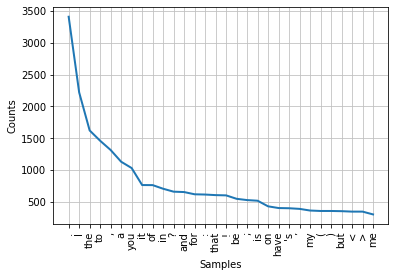

In [5]:
from nltk.probability import FreqDist

fdist = FreqDist(main_words)

fdist.plot(30,cumulative=False)
plt.show()

When we start training our own model we will be using a method where we store each word along wiht its frequency and train a model using those features (the words and frequency) along with labels (positive and negative).

We will need 2 functions. One to clean out data, removing noise such as meaningless words, punctuation etc. that could introduce greater inacuracy to our analysis. Then we need a function to convert a stream of words into a hashmap with words and number of occurences. 

In [6]:
download('stopwords')
download('names')

from nltk.corpus import stopwords, names
from string import punctuation

name_words = set([n.lower() for n in names.words()])
stop_words = set(stopwords.words("english"))

def clean_words(words):
    return [w for w in [w.lower() for w in words if w.isalpha()] if w not in stop_words and w not in name_words and w not in punctuation]

def word_counts(words):
    counts = {}
    for word in words:
        counts[word] = counts.get(word, 0) + 1
    return counts

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruairi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /Users/ruairi/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [7]:
main_words = clean_words(main_words)
main_words_counts = word_counts(main_words)

Let's see what effect that had.

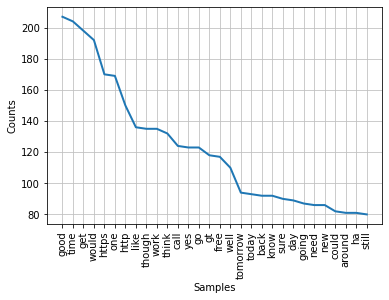

In [8]:
fdist = FreqDist(main_words)
fdist.plot(30,cumulative=False)
plt.show()

We will come back to those values later. First we will work on training a model from existing labelled data sets.

## Training Our Own Model

Using a pre-trained model works to some degree but isn't very interesting. Let's look at training our own model and using it to classify the data we prepared earlier. 

We are going to train a model using various data sets with text that is labelled as positive or negative. We are going to do some processing on this data to split it up into words with labels. This is called extracting features.

We are going to take some datasets from a couple of places and put them all together to create our features.

First let's read some data stored in this repository which was downloaded from <https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences>. These files contain text with a label `0` for negative and `1` for positive.

In [9]:
import pandas as pd

amazon = pd.read_csv('sentiment_labelled_sentences/amazon_cells_labelled.txt', names=['review', 'sentiment'], sep='\t') 
imdb = pd.read_csv('sentiment_labelled_sentences/imdb_labelled.txt', names=['review', 'sentiment'], sep='\t') 
yelp = pd.read_csv('sentiment_labelled_sentences/yelp_labelled.txt', names=['review', 'sentiment'], sep='\t') 

NLTK also provides some labelled data in its corpus. Let's grab that too for good measure.

In [10]:
download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/ruairi/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

### Split the Data

Let's process all the data into 2 collections of positive and negative. We use 2 helper functions that we created earlier. One to clean up the data set. The other to create the hashmap of words with their number of occurrences. 

In [11]:
reviews = [*amazon['review'].values, *imdb['review'].values, *yelp['review'].values]
sentiment = [*amazon['sentiment'].values, *imdb['sentiment'].values, *yelp['sentiment'].values]

positive_reviews = []
negative_reviews = []

from nltk.corpus import movie_reviews

# Process the corpus data which is split into files with IDs of pos and neg
for f in movie_reviews.fileids('pos'):
    positive_reviews.append((word_counts(clean_words(movie_reviews.words(f))), 'pos'))
for f in movie_reviews.fileids('neg'):
    negative_reviews.append((word_counts(clean_words(movie_reviews.words(f))), 'neg'))

# Process the data we extracted from files into reviews and sentiment lists with matching indexes  
for i, r in enumerate(reviews):
    review_words = word_tokenize(r)
    if sentiment[i] == 1:
        positive_reviews.append((word_counts(clean_words(review_words)), 'pos'))
    else:
        negative_reviews.append((word_counts(clean_words(review_words)), 'neg'))


Now we have all that training data, let's train a model.

We will use an 80/20 split which [may or may not be optimal here](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validation).

In [12]:
from nltk.classify import NaiveBayesClassifier

# We will use 80% of the data set for training and 20% for testing
split_pct = .80

pos_split = int(len(positive_reviews)*split_pct)
neg_split = int(len(negative_reviews)*split_pct)

train_set = positive_reviews[:pos_split] + negative_reviews[:neg_split]
test_set = positive_reviews[pos_split:] + negative_reviews[neg_split:]

model = NaiveBayesClassifier.train(train_set)

Let's pass our data in an see what happens.

In [13]:
model.classify(main_words_counts)

'pos'

How accurate was our model? We can check it agains the test data.

In [14]:
from nltk.classify.util import accuracy

print(100 * accuracy(model, test_set))

64.03785488958991


The accuracy is not great. 

We can inspect where things went wrong. By listing the guesses that were incorrect, perhaps we can figure out how to work on our features to improve accuracy. 

In [15]:
errors = []
for (data, label) in test_set:
    guess = model.classify(data)
    if guess != label:
        errors.append((label, guess, data))

print(errors[0])

('pos', 'neg', {'burger': 1, 'good': 1, 'beef': 1, 'cooked': 1, 'right': 1})


We can see what our model thinks are the most informative features. The most informative featues in this case are words that appear far more frequently with the label `pos` or the label `neg`.

In [16]:
model.show_most_informative_features()

Most Informative Features
               wonderful = 2                 pos : neg    =     14.9 : 1.0
                  avoids = 1                 pos : neg    =     12.9 : 1.0
                   sucks = 1                 neg : pos    =     12.3 : 1.0
              astounding = 1                 pos : neg    =     12.2 : 1.0
                     bad = 5                 neg : pos    =     11.8 : 1.0
                    slip = 1                 pos : neg    =     11.6 : 1.0
               ludicrous = 1                 neg : pos    =     11.1 : 1.0
             fascination = 1                 pos : neg    =     10.9 : 1.0
                seamless = 1                 pos : neg    =     10.9 : 1.0
               insulting = 1                 neg : pos    =     10.7 : 1.0


There are a couple more things we can do to help our model. 

We setup our word frequencies with a word and number of occurences. This is not actually needed and if anything makes the model less accurate because it can differentiate related words even more.

The FreqDist class gives us another utility to look for something called hapaxes which are words that only appear once in a given context. Removing these can improve the training of or model since the rarety of them is less indicative of sentiment. 

In [24]:
positive_reviews = []
negative_reviews = []

def word_frequencies(reviews):
    return FreqDist(word for review in reviews for word in review[0])

for f in movie_reviews.fileids('pos'):
    positive_reviews.append((movie_reviews.words(f), 'pos'))
for f in movie_reviews.fileids('neg'):
    negative_reviews.append((movie_reviews.words(f), 'neg'))

for i, r in enumerate(reviews):
    review_words = word_tokenize(r)
    if sentiment[i] == 1:
        positive_reviews.append((review_words, 'pos'))
    else:
        negative_reviews.append((review_words, 'neg'))
        
pos_hapaxes = set(word_frequencies(positive_reviews).hapaxes())
neg_hapaxes = set(word_frequencies(negative_reviews).hapaxes())



def word_occurrences(words):
    word_occurs = {}
    for word in words:
        word_occurs[word] = True
    return word_occurs

pos_features = [(word_occurrences([w for w in clean_words(r) if w not in pos_hapaxes]),tag) for r, tag in positive_reviews]
neg_features = [(word_occurrences([w for w in clean_words(r) if w not in neg_hapaxes]),tag) for r, tag in negative_reviews]


def split_set(review_set):
    split = int(len(review_set) * split_pct)
    return (review_set[:split], review_set[split:])

import random
random.seed(42)
random.shuffle(pos_features)
random.shuffle(neg_features)

train_pos, test_pos = split_set(pos_features)
train_neg, test_neg = split_set(neg_features)

train_set = train_pos + train_neg
test_set = test_pos + test_neg

model = NaiveBayesClassifier.train(train_set)

Let's inspect the model.

In [25]:
print(100 * accuracy(model, test_set))
model.show_most_informative_features()

83.70136698212409
Most Informative Features
               ludicrous = True              neg : pos    =     13.1 : 1.0
               insulting = True              neg : pos    =     11.8 : 1.0
            effortlessly = True              pos : neg    =     11.6 : 1.0
             outstanding = True              pos : neg    =     11.3 : 1.0
               exquisite = True              pos : neg    =     10.2 : 1.0
                    taxi = True              pos : neg    =     10.2 : 1.0
           embarrassment = True              neg : pos    =      9.8 : 1.0
                   fares = True              neg : pos    =      9.8 : 1.0
             uninvolving = True              neg : pos    =      9.8 : 1.0
               animators = True              pos : neg    =      9.6 : 1.0


We should update the slack data.

In [27]:
main_features = dict.fromkeys(main_words_counts, 0)

In [28]:
model.classify(main_features)

'neg'

## Using a Model for Real

Now we can save the model. You could push this model up somewhere and pull it in to some other useful location. For an example of how to deploy this model in a web service using docker please see the [Readme for this project](https://github.com/ruarfff/slack-sentiment/blob/main/README.md).

You can imagine some process whereby you train a model at some interval or on some event and push the model to some location that gets pulled down for use in some application or service.

In [29]:
import pickle

model_file = open('.models/sentiment_classifier.pickle','wb')
pickle.dump(model, model_file)
model_file.close()

Just to show one way you might take that file and use it elsewhere.

In [30]:
model_file = open('.models/sentiment_classifier.pickle', 'rb')
model = pickle.load(model_file)
model_file.close()

print(100 * accuracy(model, test_set))
model.show_most_informative_features()
model.classify(main_features)

83.70136698212409
Most Informative Features
               ludicrous = True              neg : pos    =     13.1 : 1.0
               insulting = True              neg : pos    =     11.8 : 1.0
            effortlessly = True              pos : neg    =     11.6 : 1.0
             outstanding = True              pos : neg    =     11.3 : 1.0
               exquisite = True              pos : neg    =     10.2 : 1.0
                    taxi = True              pos : neg    =     10.2 : 1.0
           embarrassment = True              neg : pos    =      9.8 : 1.0
                   fares = True              neg : pos    =      9.8 : 1.0
             uninvolving = True              neg : pos    =      9.8 : 1.0
               animators = True              pos : neg    =      9.6 : 1.0


'neg'